# Mid term 1

## Objective
Compare two algorithms we studied, K-NN and Logistic
Regression, in terms of accuracy and training time

In [45]:
# import libraries
import numpy as np
from numpy.random import Generator
import matplotlib.pyplot as plt
import time

In [46]:
# Function to load a dataset 
def load_dataset(path):
    data = np.load(path)
    dataset = {
        'Xtr': data['X_train'],
        'Ytr': data['y_train'],
        'Xte': data['X_test'],
        'Yte': data['y_test'],
        'feature_dim': data['feature_dim'].item(),
        'n_samples': data['n_samples'].item()
    }
    data.close()
    return dataset

# Load all three datasets
d2 = load_dataset('synthetic_linear_gaussian/linsep_d2_n200.npz')
d10 = load_dataset('synthetic_linear_gaussian/linsep_d10_n1000.npz')
d500 = load_dataset('synthetic_linear_gaussian/linsep_d500_n50000.npz')



In [47]:
# KNN functions
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    #  : Implement the computation of the pairwise Euclidean distances
    # Expected output:
    # D is a (n1 × n2) array, where D[i, j] equals the Euclidean distance
    # between the i-th sample in X1 and the j-th sample in X2.

    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            D[i, j] = euclidDistance(X1[i], X2[j])

    return D

def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0]  # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte, Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # Hint 1: take all the distances for the current test point
        # Hint 2: Sort the indices of the distances
        # Hint 3: Get the indices of the k lowest of distances
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.
        
        Ypred[idx] = np.sign(np.mean(Ytr[np.argsort(dist[idx])[:k]]))
    return Ypred

def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [48]:
# K-Fold Cross Validation for kNN
def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)

def KFoldCVkNN(Xtr, Ytr, num_folds, k_list, rng: int | Generator | None = None):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rng = _check_random_generator(rng)
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(k_list):
            #  : Compute the training error of the kNN classifier for the given value of k
            tr_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_train), y_train)
            #  : Compute the validation error of the kNN classifier for the given value of k
            val_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std


Evaluating d2 (2 features, 200 samples)
Best K found by CV: 15
CV Average Training Error for K*: 0.115
CV Average Validation Error for K*: 0.133
Training Error for K*: 0.120
Test Error for K*: 0.120
Training Time: 5.355 seconds


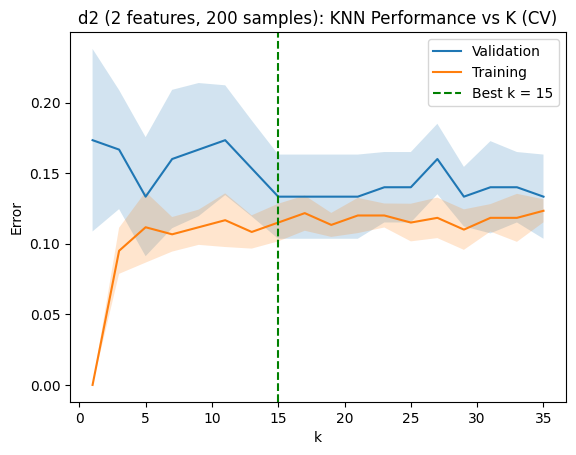


Evaluating d10 (10 features, 1000 samples)
Best K found by CV: 33
CV Average Training Error for K*: 0.156
CV Average Validation Error for K*: 0.176
Training Error for K*: 0.152
Test Error for K*: 0.148
Training Time: 130.078 seconds


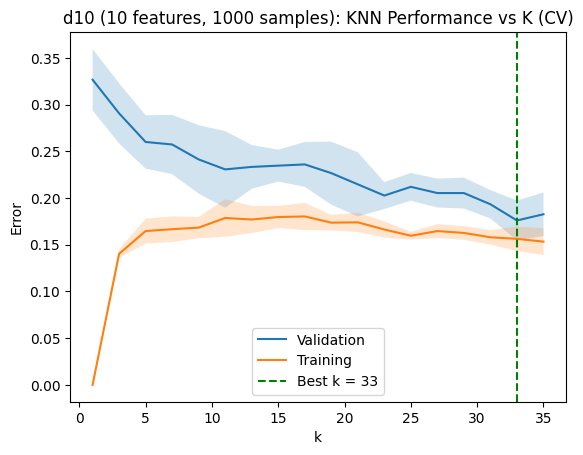


SUMMARY COMPARISON ACROSS DATASETS
Dataset              Best K   Train Error  Test Error   Time (s)  
------------------------------------------------------------
d2                   15       0.120        0.120        5.3546    
d10                  33       0.152        0.148        130.0781  


In [49]:
# KNN testing and evaluation
k_values = list(range(1, 36, 2))

# Function to perform cross-validation and evaluation for a dataset
def evaluate_knn(dataset, dataset_name):
    print(f"\n{'='*50}")
    print(f"Evaluating {dataset_name}")
    print(f"{'='*50}")
    
    Xtr, Ytr, Xte, Yte = dataset['Xtr'], dataset['Ytr'], dataset['Xte'], dataset['Yte']
    
    start_time = time.time()
    # Cross-validation to find best K using custom KFoldCVkNN
    best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
        Xtr, Ytr, num_folds=5, k_list=k_values, rng=42
    )
    training_time = time.time() - start_time
    
    print(f"Best K found by CV: {best_k}")
    print(f"CV Average Training Error for K*: {tr_err_mean[best_k_idx][0]:.3f}")
    print(f"CV Average Validation Error for K*: {val_err_mean[best_k_idx][0]:.3f}")
    
    # Final training with best K
    Ypred_tr = kNNClassify(Xtr, Ytr, best_k, Xtr)
    training_error = calcError(Ypred_tr, Ytr)
    
    # Test with best K
    Ypred_te = kNNClassify(Xtr, Ytr, best_k, Xte)
    test_error = calcError(Ypred_te, Yte)
    
    print(f"Training Error for K*: {training_error:.3f}")
    print(f"Test Error for K*: {test_error:.3f}")
    print(f"Training Time: {training_time:.3f} seconds")
    
    # Plotting the results
    fig, ax = plt.subplots()
    ax.plot(k_values, val_err_mean, label="Validation")
    ax.fill_between(k_values, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(k_values, tr_err_mean, label="Training")
    ax.fill_between(k_values, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

    ax.axvline(x=best_k, color='g', linestyle='--', label=f'Best k = {best_k}')
    ax.set_title(f'{dataset_name}: KNN Performance vs K (CV)')
    ax.set_ylabel("Error")
    ax.set_xlabel("k")
    ax.legend()
    plt.show()
    
    return best_k, training_error, test_error, training_time

# Evaluate all datasets
results = {}

# For d2 dataset
results['d2'] = evaluate_knn(d2, 'd2 (2 features, 200 samples)')

# For d10 dataset  
results['d10'] = evaluate_knn(d10, 'd10 (10 features, 1000 samples)')

# For d500 dataset
#results['d500'] = evaluate_knn(d500, 'd500 (500 features, 50000 samples)') 
#calculation for d500 dataset is too long, so i did not run it

# Print summary comparison
print(f"\n{'='*60}")
print("SUMMARY COMPARISON ACROSS DATASETS")
print(f"{'='*60}")
print(f"{'Dataset':<20} {'Best K':<8} {'Train Error':<12} {'Test Error':<12} {'Time (s)':<10}")
print(f"{'-'*60}")
for name, (best_k, train_err, test_err, train_time) in results.items():
    print(f"{name:<20} {best_k:<8} {train_err:<12.3f} {test_err:<12.3f} {train_time:<10.4f}")

In [50]:
# Logistic Regression functions
def optimal_gd_learning_rate(Xtr, reg_par):
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    # Calculate L: the Lipschitz constant of the gradient
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

def train_logreg_sgd(Xtr, Ytr, reg_par, epsilon = 1e-6, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    epsilon :  the tolerance for the stopping criterion
    maxiter : the maximum number of gradient-descent iterations
    """
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence?
        gamma = 1 / np.sqrt(n)

        # TODO: Choose the sample current sample from Xtr **at random**
        sample_idx = np.random.randint(0, n)
        x_i = Xtr[sample_idx:sample_idx+1, :] 
        y_i = Ytr[sample_idx:sample_idx+1, :]  

        # TODO: Use the formulas from the slides to update the weight vector    
        w = w - gamma * (-(x_i.T * y_i) / (1 + np.exp(y_i * (x_i @ w))) + 2 * reg_par * w)

        # TODO: Calculate the loss on the current sample
        loss = np.mean(np.log(1 + np.exp(-Ytr * (Xtr @ w)))) + reg_par * np.sum(w**2)
        training_losses[j] = loss

        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break

    return w, training_losses[:j]

def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors
    return np.sign(ypred).reshape(-1), ppred.reshape(-1)

def calcError(Ypred, Y):
    return np.mean(Ypred != Y)

In [51]:
#  K-Fold Cross Validation function for logistic regression
def KFoldCVLogReg(Xtr, Ytr, num_folds, lambda_list, rng: int | np.random.Generator | None = None):
    """Run K-Fold CV for the Logistic Regression model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - lambda_list : List[float]
         the values of lambda (regularization) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_lambda : float
         The value of lambda (in lambda_list) which obtains the best average validation error
     - best_lambda_idx : int
         The index of the best_lambda element in lambda_list
     - tr_err_mean : np.array
         A 1D array of the same length as lambda_list, with the average training error for each tested lambda.
     - tr_err_std : np.array
         A 1D array of the same length as lambda_list, with the standard deviation 
         of the training error for each tested lambda.
     - val_err_mean : np.array
         A 1D array of the same length as lambda_list, with the average validation error for each tested lambda.
     - val_err_std : np.array
         A 1D array of the same length as lambda_list, with the standard deviation
         of the validation error for each tested lambda.
    """
    rng = _check_random_generator(rng)
    # Ensures that lambda_list is a numpy array
    lambda_list = np.array(lambda_list)
    num_lambda = len(lambda_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `lambda` and each fold
    tr_errors = np.zeros((num_lambda, num_folds))
    val_errors = np.zeros((num_lambda, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for lambda_idx, current_lambda in enumerate(lambda_list):
            # Train logistic regression on fold training data
            w, _ = train_logreg_sgd(x_train, y_train, current_lambda,maxiter=10000)
            
            # Compute training error
            tr_errors[lambda_idx, fold_idx] = calcError(predict_logreg(w, x_train), y_train)
            
            # Compute validation error
            val_errors[lambda_idx, fold_idx] = calcError(predict_logreg(w, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best lambda (lambda which minimize mean validation error) and index of best lambda in lambda_list
    best_lambda_idx = np.argmin(val_err_mean)
    best_lambda = lambda_list[best_lambda_idx]
    
    return best_lambda, best_lambda_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std


Evaluating d2 (2 features, 200 samples) - Logistic Regression
Best lambda found by CV: 0.00000000000010000000
CV Average Training Error for λ*: 0.555
CV Average Validation Error for λ*: 0.550
Training Error for λ*: 0.120
Test Error for λ*: 0.120
Training Time: 1.312 seconds


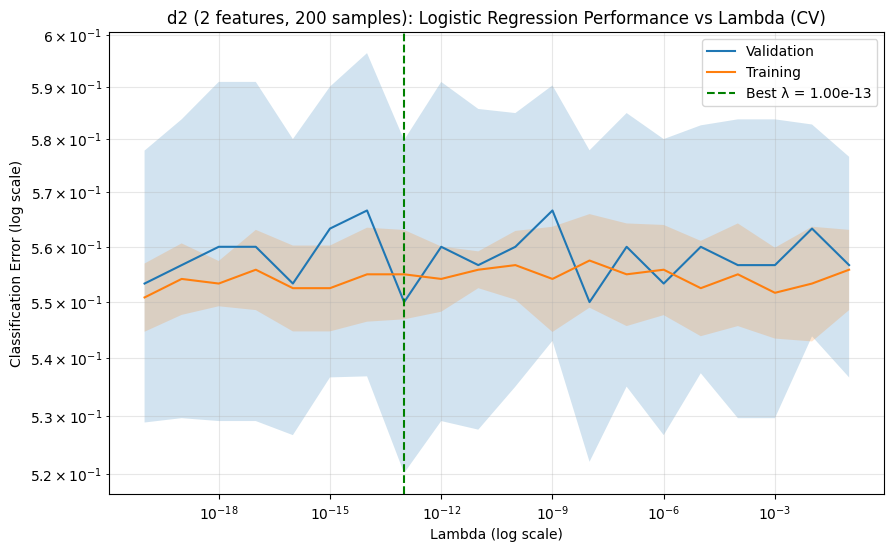


Evaluating d10 (10 features, 1000 samples) - Logistic Regression
Best lambda found by CV: 0.00000010000000000000
CV Average Training Error for λ*: 0.570
CV Average Validation Error for λ*: 0.569
Training Error for λ*: 0.175
Test Error for λ*: 0.192
Training Time: 2.671 seconds


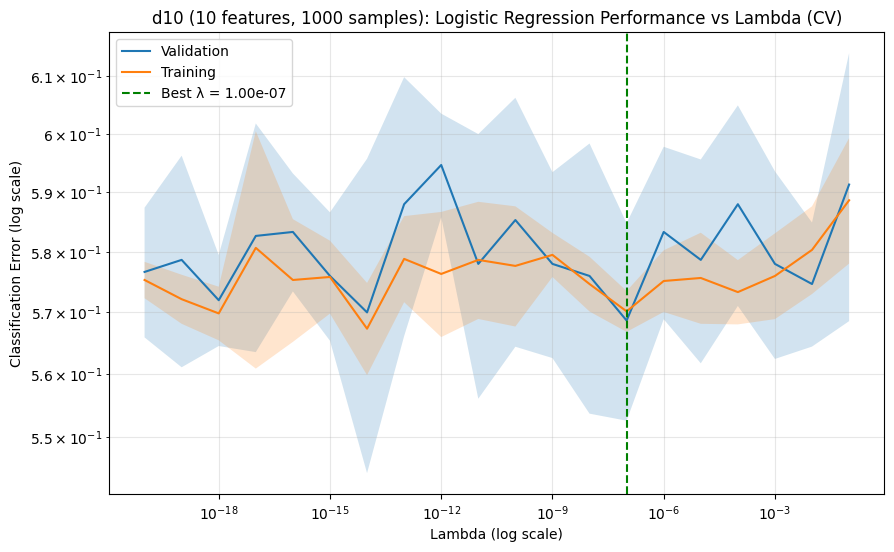


SUMMARY COMPARISON ACROSS DATASETS - LOGISTIC REGRESSION
Dataset              Best λ               Train Error  Test Error   Time (s)  
----------------------------------------------------------------------
d2                   0.000000     0.120        0.120        1.3123    
d10                  0.000000     0.175        0.192        2.6707    


In [52]:
#Logistic Regression testing and evaluation
lambda_values = np.logspace(-20, -1, 20)  # From 1e-10 to 0.1

# Function to perform cross-validation and evaluation for a dataset
def evaluate_logreg(dataset, dataset_name):
    print(f"\n{'='*50}")
    print(f"Evaluating {dataset_name} - Logistic Regression")
    print(f"{'='*50}")
    
    Xtr, Ytr, Xte, Yte = dataset['Xtr'], dataset['Ytr'], dataset['Xte'], dataset['Yte']
    
    start_time = time.time()
    # Cross-validation to find best lambda using custom KFoldCVLogReg
    best_lambda, best_lambda_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVLogReg(
        Xtr, Ytr, num_folds=5, lambda_list=lambda_values, rng=42
    )
    training_time = time.time() - start_time
    
    print(f"Best lambda found by CV: {best_lambda:.20f}")
    print(f"CV Average Training Error for λ*: {tr_err_mean[best_lambda_idx]:.3f}")
    print(f"CV Average Validation Error for λ*: {val_err_mean[best_lambda_idx]:.3f}")
    
    # Final training with best lambda
    w, training_losses = train_logreg_sgd(Xtr, Ytr, best_lambda)
    
    # Training error with best lambda
    Ypred_tr, _ = predict_logreg(w, Xtr)
    training_error = calcError(Ypred_tr, Ytr)
    
    # Test with best lambda
    Ypred_te, _ = predict_logreg(w, Xte)
    test_error = calcError(Ypred_te, Yte)
    
    print(f"Training Error for λ*: {training_error:.3f}")
    print(f"Test Error for λ*: {test_error:.3f}")
    print(f"Training Time: {training_time:.3f} seconds")
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(lambda_values, val_err_mean, label='Validation')
    ax.fill_between(lambda_values, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.loglog(lambda_values, tr_err_mean, label='Training')
    ax.fill_between(lambda_values, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

    ax.axvline(x=best_lambda, color='g', linestyle='--', label=f'Best λ = {best_lambda:.2e}')
    ax.set_title(f'{dataset_name}: Logistic Regression Performance vs Lambda (CV)')
    ax.set_ylabel('Classification Error (log scale)')
    ax.set_xlabel('Lambda (log scale)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()
    
    return best_lambda, training_error, test_error, training_time

# Evaluate all datasets
logreg_results = {}

# For d2 dataset
logreg_results['d2'] = evaluate_logreg(d2, 'd2 (2 features, 200 samples)')

# For d10 dataset  
logreg_results['d10'] = evaluate_logreg(d10, 'd10 (10 features, 1000 samples)')

# For d500 dataset
#logreg_results['d500'] = evaluate_logreg(d500, 'd500 (500 features, 50000 samples)')
#calculation for d500 dataset is too long, so i did not run it

# Print summary comparison
print(f"\n{'='*70}")
print("SUMMARY COMPARISON ACROSS DATASETS - LOGISTIC REGRESSION")
print(f"{'='*70}")
print(f"{'Dataset':<20} {'Best λ':<20} {'Train Error':<12} {'Test Error':<12} {'Time (s)':<10}")
print(f"{'-'*70}")
for name, (best_lambda, train_err, test_err, train_time) in logreg_results.items():
    print(f"{name:<20} {best_lambda:<12.6f} {train_err:<12.3f} {test_err:<12.3f} {train_time:<10.4f}")